In [1]:
import csv
import pandas as pd
import numpy as np
import json
import jsonlines
import re
from termcolor import colored
csv.field_size_limit(100000000)

from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import shap

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

try:
    from urllib.parse import urlparse
except ImportError:
     from urlparse import urlparse
%matplotlib inline 

import matplotlib.dates as mdates
import matplotlib.ticker as tick

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None
pd.options.display.max_rows = None

pd.options.display.float_format = '{:.4f}'.format

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# RandomForestClassifier
## TweetsCov19
### (Tweet content + user features)

In [2]:
path = '../data/df_tweetscov19_sample_200000_23.tsv'

df_tweetscov19_user = pd.read_csv(path, sep='\t', error_bad_lines=False, names=['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Sentiment negative', 'Sentiment neutral', 'Sentiment positive', 'Sentiment compound', 'Number of hashtags', 'Number od mentions', 'Text length', 'Number of URLs', 'Readability', 'Number of Emojis', 'Emoji_sent', 'Political polarisation (tweet based)', 'Science polarisation (tweet based)', 'Moderacy polarisation (tweet based)', 'Social', 'Family', 'Friend', 'Female', 'Male' , 'Work', 'Leisure', 'Home', 'Money', 'Relegion', 'Death', 'Informal', 'Swear', 'Netspeak', 'Assent', 'Nonflu', 'Filler', 'Body', 'Health', 'Sexual', 'Ingest', 'Posemo', 'Negemo', 'Anx', 'Anger', 'Sad', 'Insight', 'Cause', 'Discrep', 'Tentat', 'Certain', 'Differ', 'Affiliation', 'Achiev', 'Power', 'Reward', 'Risk', 'Focuspast', 'Focuspresent', 'Focusfuture', 'I', 'We', 'You', 'SheHe', 'They', 'Ipron', 'Article', 'Prep', 'Auxverb', 'Adverb', 'Conj', 'Negate', 'Verb', 'Adj', 'compare', 'Interrog', 'Number', 'Quant', 'See', 'Hear', 'Feel', 'Motion', 'Space', 'Time', 'Political polarisation (user based)', 'Science polarisation (user based)', 'Moderacy polarisation (user based)', 'Posted_tweets (per user)', 'Deleted_tweets (per user)', 'Deletion_ratio (user)', 'Reputation (user)', 'Is_deleted', 'User sentiment average', 'Tweet sentiment deviation', 'Tweet political polarisation deviation', 'Tweet science polarisation deviation', 'Tweet moderacy polarisation deviation'])

print('Shape :', df_tweetscov19_user.shape)
df_tweetscov19_user.head()

Shape : (200000, 95)


,Tweet_Id,Username,Retweets,Favorites,Sentiment negative,Sentiment neutral,Sentiment positive,Sentiment compound,Number of hashtags,Number od mentions,Text length,Number of URLs,Readability,Number of Emojis,Emoji_sent,Political polarisation (tweet based),Science polarisation (tweet based),Moderacy polarisation (tweet based),Social,Family,Friend,Female,Male,Work,Leisure,Home,Money,Relegion,Death,Informal,Swear,Netspeak,Assent,Nonflu,Filler,Body,Health,Sexual,Ingest,Posemo,Negemo,Anx,Anger,Sad,Insight,Cause,Discrep,Tentat,Certain,Differ,Affiliation,Achiev,Power,Reward,Risk,Focuspast,Focuspresent,Focusfuture,I,We,You,SheHe,They,Ipron,Article,Prep,Auxverb,Adverb,Conj,Negate,Verb,Adj,compare,Interrog,Number,Quant,See,Hear,Feel,Motion,Space,Time,Political polarisation (user based),Science polarisation (user based),Moderacy polarisation (user based),Posted_tweets (per user),Deleted_tweets (per user),Deletion_ratio (user),Reputation (user),Is_deleted,User sentiment average,Tweet sentiment deviation,Tweet political polarisation deviation,Tweet science polarisation deviation,Tweet moderacy polarisation deviation
0,1254069159098322947,4e8e74c47b8950e4b3954c86732007f6,0,0,-0.0000,1.0000,0.0000,0.0000,0,0,17,0,35.6050,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,33.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,33.3300,0.0000,0.0000,0.0000,1,1,1.0000,0.6264,True,0.0000,0.0000,0.0000,0.0000,0.0000
1,1249258619562070019,bd41ec450084d9a16582b6fccbddcc9f,0,0,-0.2710,0.7290,0.0000,-0.3818,0,0,72,1,40.0900,0,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,9.0900,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,-1.0000,10,10,1.0000,1.0000,True,0.4501,-0.8319,-1.0000,0.0000,1.0000
2,1244312339756834817,4de0b1281cf756ea9707014c816679a1,0,0,-0.2100,0.4330,0.3570,0.3336,1,0,66,0,75.5000,1,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,9.0900,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.4861,True,0.3336,0.0000,0.0000,0.0000,0.0000
3,1182296312932384768,a28f24f00de6b0aebb557d27f9c51500,0,0,-0.0000,1.0000,0.0000,0.0000,0,0,93,0,80.0980,2,-0.1710,0.0000,0.0000,0.0000,10.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000,20.0000,5.0000,0.0000,0.0000,5.0000,0.0000,0.0000,15.0000,0.0000,10.0000,10.0000,0.0000,5.0000,0.0000,30.0000,5.0000,5.0000,5.0000,0.0000,0.0000,0.0000,5.0000,0.0000,10.0000,5.0000,10.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.5193,True,0.0000,0.0000,0.0000,0.0000,0.0000
4,1240046019548721156,a52194236f9679e4183863c3583c6178,0,0,-0.1310,0.8690,0.0000,-0.2755,0,1,111,1,61.2400,0,0.0000,0.0000,0.0000,0.0000,11.1100,0.0000,0.0000,0.0000,0.0000,5.5600,0.0000,0.0000,0.0000,0.0000,0.0000

In [3]:
df_tweetscov19_user = df_tweetscov19_user.sample(frac=1).reset_index(drop=True)

print('Shape: ', df_tweetscov19_user.shape)
df_tweetscov19_user.head()

Shape:  (200000, 95)


,Tweet_Id,Username,Retweets,Favorites,Sentiment negative,Sentiment neutral,Sentiment positive,Sentiment compound,Number of hashtags,Number od mentions,Text length,Number of URLs,Readability,Number of Emojis,Emoji_sent,Political polarisation (tweet based),Science polarisation (tweet based),Moderacy polarisation (tweet based),Social,Family,Friend,Female,Male,Work,Leisure,Home,Money,Relegion,Death,Informal,Swear,Netspeak,Assent,Nonflu,Filler,Body,Health,Sexual,Ingest,Posemo,Negemo,Anx,Anger,Sad,Insight,Cause,Discrep,Tentat,Certain,Differ,Affiliation,Achiev,Power,Reward,Risk,Focuspast,Focuspresent,Focusfuture,I,We,You,SheHe,They,Ipron,Article,Prep,Auxverb,Adverb,Conj,Negate,Verb,Adj,compare,Interrog,Number,Quant,See,Hear,Feel,Motion,Space,Time,Political polarisation (user based),Science polarisation (user based),Moderacy polarisation (user based),Posted_tweets (per user),Deleted_tweets (per user),Deletion_ratio (user),Reputation (user),Is_deleted,User sentiment average,Tweet sentiment deviation,Tweet political polarisation deviation,Tweet science polarisation deviation,Tweet moderacy polarisation deviation
0,1241583093586120706,b43f7379cb43dd05198d54213778fad3,0,0,-0.0000,1.0000,0.0000,0.0000,5,2,148,0,22.4080,0,0.0000,0.0000,0.0000,0.0000,5.5600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.5600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,11.1100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.5600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,11.1100,0.0000,0.0000,0.0000,0.0000,5.5600,0.0000,5.5600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.0000,True,0.0000,0.0000,0.0000,0.0000,0.0000
1,1233450800208207872,dd915c789d6976cabe46b6dcf2c459df,80,124,-0.0000,0.7560,0.2440,0.9059,0,0,274,0,57.2340,0,0.0000,0.0000,0.0000,0.0000,11.3600,0.0000,0.0000,0.0000,0.0000,6.8200,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.8200,2.2700,0.0000,2.2700,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,2.2700,6.8200,2.2700,4.5500,0.0000,4.5500,13.6400,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,2.2700,0.0000,9.0900,6.8200,6.8200,9.0900,2.2700,11.3600,6.8200,4.5500,2.2700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.8200,6.8200,0.0000,0.0000,0.0000,10,0,0.0000,0.9776,False,0.1951,0.7108,0.0000,0.0000,0.0000
2,1239993217463881728,e8d34959aa76d941adecdc70f5294ad8,0,0,-0.0880,0.8890,0.0230,-0.6206,2,1,290,0,74.2360,0,0.0000,0.0000,0.0000,0.0000,15.5600,0.0000,0.0000,0.0000,0.0000,0.0000,6.6700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.4400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.2200,2.2200,2.2200,0.0000,0.0000,0.0000,4.4400,4.4400,2.2200,0.0000,2.2200,6.6700,0.0000,0.0000,8.8900,2.2200,15.5600,6.6700,6.6700,2.2200,0.0000,11.1100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.6700,2.2200,2.2200,0.0000,0.0000,0.0000,3,0,0.0000,0.3815,False,-0.4663,-0.1543,0.0000,0.0000,0.0000
3,1250769156217147392,6a8126906ea0197abf1132da1209e290,0,0,-0.0000,0.9090,0.0910,0.4939,0,0,272,0,35.1200,0,0.0000,0.0000,0.0000,0.0000,2.7000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.7000,0.0000,0.0000,2.7000,0.0000,5.4100,0.0000,0.0000,2.7000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.7000,0.0000,0.0000,0.0000,1,0,0.0000,0.0896,False,0.4939,0.0000,0.0000,0.0000,0.0000
4,1260733657255251968,f045c19ec2858847215fba36e01d09b4,339,635,-0.0000,0.8100,0.1900,0.8821,0,0,298,0,55.4320,1,0.7010,0.0000,0.0000,0.0000,1.8200,0.0000,0.0000,0.0000,0.0000,1.8200,0.0000,0.0000,0.0000,0.0000,

In [4]:
features = df_tweetscov19_user.columns
features

Index(['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Sentiment negative',
       'Sentiment neutral', 'Sentiment positive', 'Sentiment compound',
       'Number of hashtags', 'Number od mentions', 'Text length',
       'Number of URLs', 'Readability', 'Number of Emojis', 'Emoji_sent',
       'Political polarisation (tweet based)',
       'Science polarisation (tweet based)',
       'Moderacy polarisation (tweet based)', 'Social', 'Family', 'Friend',
       'Female', 'Male', 'Work', 'Leisure', 'Home', 'Money', 'Relegion',
       'Death', 'Informal', 'Swear', 'Netspeak', 'Assent', 'Nonflu', 'Filler',
       'Body', 'Health', 'Sexual', 'Ingest', 'Posemo', 'Negemo', 'Anx',
       'Anger', 'Sad', 'Insight', 'Cause', 'Discrep', 'Tentat', 'Certain',
       'Differ', 'Affiliation', 'Achiev', 'Power', 'Reward', 'Risk',
       'Focuspast', 'Focuspresent', 'Focusfuture', 'I', 'We', 'You', 'SheHe',
       'They', 'Ipron', 'Article', 'Prep', 'Auxverb', 'Adverb', 'Conj',
       'Negate', 'Verb',

In [5]:
df_tweetscov19_user['Is_deleted'] = np.where(df_tweetscov19_user['Is_deleted'] == True, 1, 0)
df_tweetscov19_user.head()

,Tweet_Id,Username,Retweets,Favorites,Sentiment negative,Sentiment neutral,Sentiment positive,Sentiment compound,Number of hashtags,Number od mentions,Text length,Number of URLs,Readability,Number of Emojis,Emoji_sent,Political polarisation (tweet based),Science polarisation (tweet based),Moderacy polarisation (tweet based),Social,Family,Friend,Female,Male,Work,Leisure,Home,Money,Relegion,Death,Informal,Swear,Netspeak,Assent,Nonflu,Filler,Body,Health,Sexual,Ingest,Posemo,Negemo,Anx,Anger,Sad,Insight,Cause,Discrep,Tentat,Certain,Differ,Affiliation,Achiev,Power,Reward,Risk,Focuspast,Focuspresent,Focusfuture,I,We,You,SheHe,They,Ipron,Article,Prep,Auxverb,Adverb,Conj,Negate,Verb,Adj,compare,Interrog,Number,Quant,See,Hear,Feel,Motion,Space,Time,Political polarisation (user based),Science polarisation (user based),Moderacy polarisation (user based),Posted_tweets (per user),Deleted_tweets (per user),Deletion_ratio (user),Reputation (user),Is_deleted,User sentiment average,Tweet sentiment deviation,Tweet political polarisation deviation,Tweet science polarisation deviation,Tweet moderacy polarisation deviation
0,1241583093586120706,b43f7379cb43dd05198d54213778fad3,0,0,-0.0000,1.0000,0.0000,0.0000,5,2,148,0,22.4080,0,0.0000,0.0000,0.0000,0.0000,5.5600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.5600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,11.1100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.5600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,11.1100,0.0000,0.0000,0.0000,0.0000,5.5600,0.0000,5.5600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.0000,1,0.0000,0.0000,0.0000,0.0000,0.0000
1,1233450800208207872,dd915c789d6976cabe46b6dcf2c459df,80,124,-0.0000,0.7560,0.2440,0.9059,0,0,274,0,57.2340,0,0.0000,0.0000,0.0000,0.0000,11.3600,0.0000,0.0000,0.0000,0.0000,6.8200,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.8200,2.2700,0.0000,2.2700,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,2.2700,6.8200,2.2700,4.5500,0.0000,4.5500,13.6400,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,2.2700,0.0000,9.0900,6.8200,6.8200,9.0900,2.2700,11.3600,6.8200,4.5500,2.2700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.8200,6.8200,0.0000,0.0000,0.0000,10,0,0.0000,0.9776,0,0.1951,0.7108,0.0000,0.0000,0.0000
2,1239993217463881728,e8d34959aa76d941adecdc70f5294ad8,0,0,-0.0880,0.8890,0.0230,-0.6206,2,1,290,0,74.2360,0,0.0000,0.0000,0.0000,0.0000,15.5600,0.0000,0.0000,0.0000,0.0000,0.0000,6.6700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.4400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.2200,2.2200,2.2200,0.0000,0.0000,0.0000,4.4400,4.4400,2.2200,0.0000,2.2200,6.6700,0.0000,0.0000,8.8900,2.2200,15.5600,6.6700,6.6700,2.2200,0.0000,11.1100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.6700,2.2200,2.2200,0.0000,0.0000,0.0000,3,0,0.0000,0.3815,0,-0.4663,-0.1543,0.0000,0.0000,0.0000
3,1250769156217147392,6a8126906ea0197abf1132da1209e290,0,0,-0.0000,0.9090,0.0910,0.4939,0,0,272,0,35.1200,0,0.0000,0.0000,0.0000,0.0000,2.7000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.7000,0.0000,0.0000,2.7000,0.0000,5.4100,0.0000,0.0000,2.7000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.7000,0.0000,0.0000,0.0000,1,0,0.0000,0.0896,0,0.4939,0.0000,0.0000,0.0000,0.0000
4,1260733657255251968,f045c19ec2858847215fba36e01d09b4,339,635,-0.0000,0.8100,0.1900,0.8821,0,0,298,0,55.4320,1,0.7010,0.0000,0.0000,0.0000,1.8200,0.0000,0.0000,0.0000,0.0000,1.8200,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0

In [6]:
#df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'user_political_polarisation','user_science_polarisation.','user_moderacy_polarisation'])
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'Tweet_Id', 'Username',  'Posted_tweets (per user)', 'Deleted_tweets (per user)', 'Deletion_ratio (user)'])

In [7]:
def get_X_y(df, features):
    
    if 'Is_deleted' not in features:
        features = np.append(features, 'Is_deleted')
        
    df = df[features.tolist()]
    X = df.drop('Is_deleted', axis=1)
    y = df['Is_deleted']

    y = y.astype(int)
    print(X.shape)
    print(y.shape)
    
    return X,y

In [8]:
features = df_tweetscov19_user.columns
X,y = get_X_y(df_tweetscov19_user, features)

(200000, 89)
(200000,)


In [9]:
def split_train_test_valid(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=15)
    #X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=15)
    print(X_train.shape)
    print(X_test.shape)
    #print(X_valid.shape)

    print(y_train.shape)
    print(y_test.shape)
    #print(y_valid.shape)
    return  X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 89)
(40000, 89)
(160000,)
(40000,)


In [59]:
def fit_random_forest_clf(X,y):

    clf = RandomForestClassifier( n_jobs=-1)
    clf.fit(X,y)
    return clf

In [60]:
def test_random_forest_clf(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    print('Accuracy :', accuracy_score(y_test, y_pred))
    

In [14]:
rf_model = fit_random_forest_clf(X_train, y_train)

In [15]:
test_random_forest_clf(rf_model, X_test, y_test)

Accuracy : 0.63915


In [16]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.54      0.60     19935
           1       0.62      0.74      0.67     20065

    accuracy                           0.64     40000
   macro avg       0.64      0.64      0.64     40000
weighted avg       0.64      0.64      0.64     40000



In [13]:
def plot_confusion_matrix(y_test, y_pred, classes, titel):
    
    confusion_mx = confusion_matrix(y_test, y_pred)
    confusion_mx = confusion_mx / confusion_mx.sum(axis=1).reshape(-1,1)
    
    sns.heatmap(confusion_mx, xticklabels = classes, yticklabels = classes, annot=True)
    plt.title(titel)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

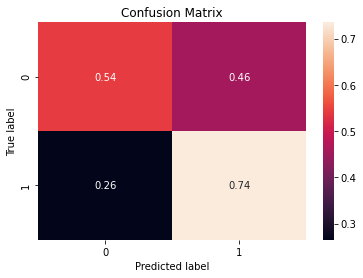

In [18]:
plot_confusion_matrix(y_test, y_pred, rf_model.classes_, 'Confusion Matrix')

***

In [14]:
def features_classifier_(df, model):

    column_feature = {}

    for i, c in enumerate(df):
        #print(c, '   ', decisionTC.feature_importances_[i])

        column_feature[c] = model.feature_importances_[i]
        #print(c)
    df_column_feature = pd.DataFrame(column_feature.items(), columns=['Feature','importance'])
    df_column_feature.sort_values(by = ['importance'], ascending = False, inplace = True)

    df_column_feature = df_column_feature.reset_index()
    df_column_feature
    return df_column_feature

In [15]:
rf_model = RandomForestClassifier(n_estimators = 300, max_features = 'sqrt',max_depth = 10, min_samples_split = 8, min_samples_leaf=1, bootstrap = True, n_jobs=-1)

rf_model.fit(X_train, y_train)

f_importances = features_classifier_(X_train, rf_model)
f_importances

,index,Feature,importance
0,83,Reputation (user),0.1550
1,82,Moderacy polarisation (user based),0.0950
2,80,Political polarisation (user based),0.0874
3,0,Retweets,0.0811
4,9,Number of URLs,0.0684
5,1,Favorites,0.0593
6,88,Tweet moderacy polarisation deviation,0.0411
7,86,Tweet political polarisation deviation,0.0356
8,8,Text length,0.0347
9,6,Number of hashtags,0.0227


In [21]:
f_importances = f_importances[f_importances['importance'] > 0.008]
f_importances = f_importances.Feature.values
print(f_importances)

['user_Reputation' 'user_political_polarisation'
 'user_moderacy_polarisation' 'URLs_num' 'Favorites' 'Retweets'
 'tweet_moderacy_polarisation_abweichung'
 'tweet_political_polarisation_abweichung' 'Text_len'
 'user_vadercompound_average' 'Hashtags_num' 'i' 'informal'
 'tweet_politic_polarisation' 'work' 'prep' 'tweet_moderacy_polarisation'
 'verb' 'readability']


In [22]:
len(f_importances)

19

In [23]:
X_new,y = get_X_y(df_tweetscov19_user, f_importances)

(200000, 19)
(200000,)


In [7]:
def print_cross_val_score(model, X, y):
    scores = cross_val_score(model, X, y, cv=10, scoring='precision')
    print(" percision : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X, y, cv=10, scoring='f1')
    print(" f1        : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X, y, cv=10, scoring='recall')
    print(" recall    : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))

In [41]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 300, max_features = 'sqrt',max_depth = 10, min_samples_split = 8, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
print_cross_val_score(clf_cv, X_new, y)

 percision : 0.61 +/- 0.009
 f1        : 0.69 +/- 0.010
 recall    : 0.79 +/- 0.020
Wall time: 44.7 s


In [42]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 300, max_features = 'sqrt',max_depth = 10, min_samples_split = 8, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
print_cross_val_score(clf_cv, X, y)

 percision : 0.61 +/- 0.009
 f1        : 0.69 +/- 0.010
 recall    : 0.78 +/- 0.016
Wall time: 50.6 s


******

***

****

In [26]:
n_estimators = [100, 200, 300, 400, 500, 1000]
max_features = ['sqrt', 'log2', 'auto']
max_depth =  [2,4,6,8,10]
min_samples_split = [2,4,8]
min_samples_leaf = [1,2,4]
bootstrap = [True, False]

In [27]:
param_grid = {'n_estimators' : n_estimators,
              'max_features' : max_features,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf,
              'bootstrap' : bootstrap}
print(param_grid)

{'n_estimators': [100, 200, 300, 400, 500, 1000], 'max_features': ['sqrt', 'log2', 'auto'], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 4, 8], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [28]:
rf_model = RandomForestClassifier()

In [31]:
%%time
clf_grid = GridSearchCV(rf_model, param_grid = param_grid, cv = 3, verbose = 2, n_jobs = -1)
clf_grid.fit(X_train,y_train)

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits
Wall time: 1h 8min 34s


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [2, 4, 6, 8, 10],
                         'max_features': ['sqrt', 'log2', 'auto'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [100, 200, 300, 400, 500, 1000]},
             verbose=2)

In [32]:
clf_grid.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 300}

In [33]:
clf_grid.score(X_test,y_test)

0.641

In [34]:
%%time
#20 000 Tweets

clf_cv = RandomForestClassifier(n_estimators = 300, max_features = 'sqrt',max_depth = 10, min_samples_split = 8, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
print_cross_val_score(clf_cv, X_new, y)


 percision : 0.61 +/- 0.009
 f1        : 0.69 +/- 0.012
 recall    : 0.79 +/- 0.019
Wall time: 45.4 s


In [25]:
%%time
#200 000 Tweets

clf_cv = RandomForestClassifier(n_estimators = 300, max_features = 'sqrt',max_depth = 10, min_samples_split = 8, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
print_cross_val_score(clf_cv, X_new, y)


 percision : 0.61 +/- 0.002
 f1        : 0.69 +/- 0.002
 recall    : 0.80 +/- 0.005
Wall time: 6min 43s


***

In [19]:
def plot_hist_Features(l_features_importances, l_features, title):
    
    #colors = ['mediumorchid', 'gold', 'green', 'peru', 'red', 'mediumslateblue', 'deepskyblue', 'darkkhaki', 'brown']
    colors = ['steelblue', 'peru', 'black', 'mediumslateblue', 'lightblue']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [14,14]
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, width = 0.5)
    ax.set_title('Random Forest', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    fig.tight_layout()
    #plt.legend()
    plt.savefig('../plots/'+title+'.pdf')


In [22]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:10]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:10]
l_features

['Reputation (user)',
 'Moderacy polarisation (user based)',
 'Political polarisation (user based)',
 'Retweets',
 'Number of URLs',
 'Favorites',
 'Tweet moderacy polarisation deviation',
 'Tweet political polarisation deviation',
 'Text length',
 'Number of hashtags']

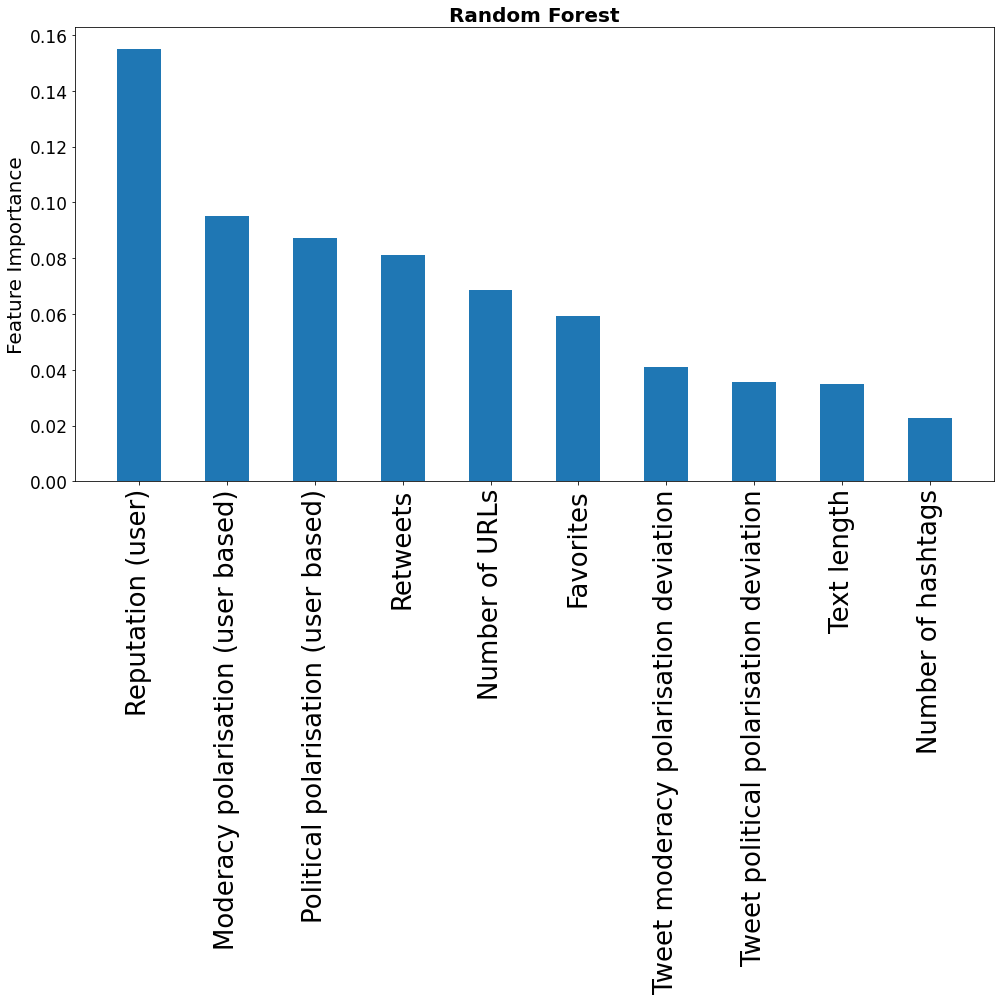

In [23]:
plot_hist_Features(l_features_importances, l_features, 'Rf_tweetscov19_content_User')

************************************************
************************************************

## TweetsCov19
### (Content only)

In [24]:
features = df_tweetscov19_user.columns
features

#features = features[2:83]
df_tweetscov19_user = df_tweetscov19_user[features.tolist()]
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'User sentiment average', 'Tweet sentiment deviation', 'Tweet political polarisation deviation', 'Tweet science polarisation deviation', 'Tweet moderacy polarisation deviation' ])
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[  'Political polarisation (user based)', 'Science polarisation (user based)', 'Moderacy polarisation (user based)', 'Reputation (user)'])


In [25]:
features = df_tweetscov19_user.columns
X,y = get_X_y(df_tweetscov19_user, features)

(200000, 80)
(200000,)


In [26]:
X_train, X_test, y_train, y_test= split_train_test_valid(X,y)

(160000, 80)
(40000, 80)
(160000,)
(40000,)


In [27]:
clf_cv = RandomForestClassifier(n_estimators = 300, max_features = 'sqrt',max_depth = 10, min_samples_split = 8, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
clf_cv.fit(X_train, y_train)

f_importances = features_classifier_(X, clf_cv)
f_importances

,index,Feature,importance
0,0,Retweets,0.1562
1,1,Favorites,0.1216
2,9,Number of URLs,0.1093
3,8,Text length,0.0527
4,56,I,0.0396
5,6,Number of hashtags,0.0373
6,13,Political polarisation (tweet based),0.0365
7,27,Informal,0.0306
8,15,Moderacy polarisation (tweet based),0.0279
9,21,Work,0.0263


In [30]:
f_importances = f_importances[f_importances['importance'] > 0.008]
f_importances = f_importances.Feature.values
print(f_importances)

['Retweets' 'Favorites' 'URLs_num' 'Text_len' 'i' 'Hashtags_num'
 'tweet_politic_polarisation' 'informal' 'tweet_moderacy_polarisation'
 'work' 'prep' 'verb' 'readability' 'swear' 'netspeak' 'ipron' 'space'
 'vader_com' 'Mentions_num' 'social' 'Vader_neg' 'adverb' 'focuspresent'
 'Vader_neu']


In [31]:
X_new,y = get_X_y(df_tweetscov19_user, f_importances)

(200000, 24)
(200000,)


In [50]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 300, max_features = 'sqrt',max_depth = 10, min_samples_split = 8, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
print_cross_val_score(rf_model, X_new, y)

 percision : 0.61 +/- 0.011
 f1        : 0.65 +/- 0.011
 recall    : 0.71 +/- 0.019
Wall time: 44.7 s


In [51]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 300, max_features = 'sqrt',max_depth = 10, min_samples_split = 8, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
print_cross_val_score(rf_model, X, y)

 percision : 0.61 +/- 0.012
 f1        : 0.65 +/- 0.013
 recall    : 0.70 +/- 0.020
Wall time: 47.1 s


********************************************************
********************************************************

In [32]:
%%time
#200 000 Tweets

clf_cv = RandomForestClassifier(n_estimators = 300, max_features = 'sqrt',max_depth = 10, min_samples_split = 8, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
print_cross_val_score(clf_cv, X_new, y)


 percision : 0.60 +/- 0.003
 f1        : 0.66 +/- 0.003
 recall    : 0.72 +/- 0.004
Wall time: 7min 46s


***

## Plot feature Imortances
### TweetCov19 (Content Only)

In [28]:
def plot_hist_Features_content_only(l_features_importances, l_features, title):
    
    #colors = ['red', 'blue', 'peru', 'orange', 'yellow', 'mediumslateblue', 'deepskyblue', 'steelblue']
    colors = ['peru', 'black', 'mediumslateblue', 'lightblue', 'lightgreen']
    
    x = np.arange(len(l_features))

    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [14,14]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, width = 0.5)
    ax.set_title('Random Forest', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=18)
    ax.set_ylabel('Feature Importance', fontsize=20)
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
    fig.tight_layout()
    

    #plt.legend()
    plt.savefig('../plots/'+title+'.pdf')


In [29]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:10]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:10]
l_features

['Retweets',
 'Favorites',
 'Number of URLs',
 'Text length',
 'I',
 'Number of hashtags',
 'Political polarisation (tweet based)',
 'Informal',
 'Moderacy polarisation (tweet based)',
 'Work']

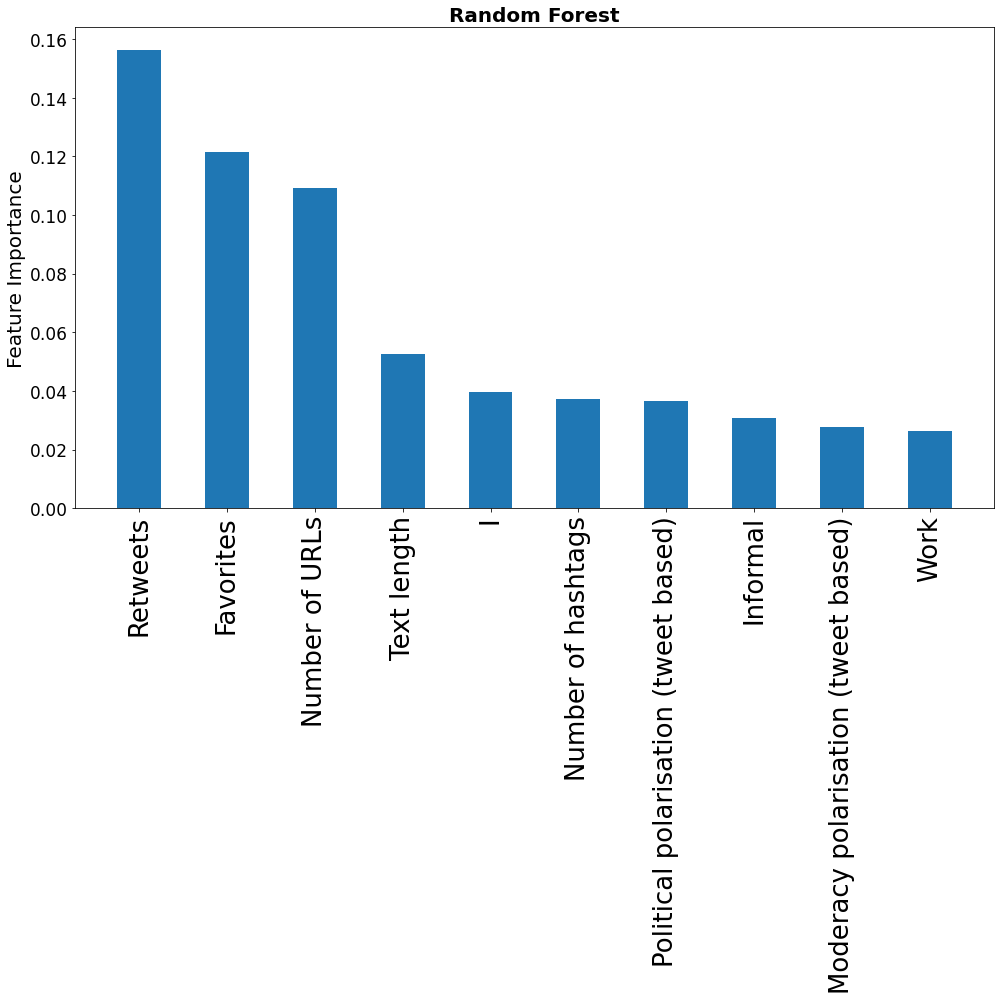

In [30]:
plot_hist_Features_content_only(l_features_importances, l_features, 'Rf_tweetscov19_content_only')

************************************************
************************************************

# Tweetskb
### (Content + User Features)

In [31]:
path = '../data/df_tweetskb_sample_200000_9.tsv'

df_tweetskb_user = pd.read_csv(path, sep='\t', error_bad_lines=False, names=['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Sentiment negative', 'Sentiment neutral', 'Sentiment positive', 'Sentiment compound', 'Number of hashtags', 'Number od mentions', 'Text length', 'Number of URLs', 'Readability', 'Number of Emojis', 'Emoji_sent', 'Political polarisation (tweet based)', 'Science polarisation (tweet based)', 'Moderacy polarisation (tweet based)', 'Social', 'Family', 'Friend', 'Female', 'Male' , 'Work', 'Leisure', 'Home', 'Money', 'Relegion', 'Death', 'Informal', 'Swear', 'Netspeak', 'Assent', 'Nonflu', 'Filler', 'Body', 'Health', 'Sexual', 'Ingest', 'Posemo', 'Negemo', 'Anx', 'Anger', 'Sad', 'Insight', 'Cause', 'Discrep', 'Tentat', 'Certain', 'Differ', 'Affiliation', 'Achiev', 'Power', 'Reward', 'Risk', 'Focuspast', 'Focuspresent', 'Focusfuture', 'I', 'We', 'You', 'SheHe', 'They', 'Ipron', 'Article', 'Prep', 'Auxverb', 'Adverb', 'Conj', 'Negate', 'Verb', 'Adj', 'compare', 'Interrog', 'Number', 'Quant', 'See', 'Hear', 'Feel', 'Motion', 'Space', 'Time', 'Political polarisation (user based)', 'Science polarisation (user based)', 'Moderacy polarisation (user based)', 'Posted_tweets (per user)', 'Deleted_tweets (per user)', 'Deletion_ratio (user)', 'Reputation (user)', 'Is_deleted', 'User sentiment average', 'Tweet sentiment deviation', 'Tweet political polarisation deviation', 'Tweet science polarisation deviation', 'Tweet moderacy polarisation deviation'])

print('Shape :', df_tweetskb_user.shape)
df_tweetskb_user.head()

Shape : (200000, 95)


,Tweet_Id,Username,Retweets,Favorites,Sentiment negative,Sentiment neutral,Sentiment positive,Sentiment compound,Number of hashtags,Number od mentions,Text length,Number of URLs,Readability,Number of Emojis,Emoji_sent,Political polarisation (tweet based),Science polarisation (tweet based),Moderacy polarisation (tweet based),Social,Family,Friend,Female,Male,Work,Leisure,Home,Money,Relegion,Death,Informal,Swear,Netspeak,Assent,Nonflu,Filler,Body,Health,Sexual,Ingest,Posemo,Negemo,Anx,Anger,Sad,Insight,Cause,Discrep,Tentat,Certain,Differ,Affiliation,Achiev,Power,Reward,Risk,Focuspast,Focuspresent,Focusfuture,I,We,You,SheHe,They,Ipron,Article,Prep,Auxverb,Adverb,Conj,Negate,Verb,Adj,compare,Interrog,Number,Quant,See,Hear,Feel,Motion,Space,Time,Political polarisation (user based),Science polarisation (user based),Moderacy polarisation (user based),Posted_tweets (per user),Deleted_tweets (per user),Deletion_ratio (user),Reputation (user),Is_deleted,User sentiment average,Tweet sentiment deviation,Tweet political polarisation deviation,Tweet science polarisation deviation,Tweet moderacy polarisation deviation
0,1234468305332654080,cacamshx,1,1,-0.0000,1.0000,0.0000,0.0000,0,0,34,0,103.5400,1,0.0000,0.0000,0.0000,0.0000,42.8600,0.0000,0.0000,14.2900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,14.2900,0.0000,0.0000,0.0000,14.2900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,14.2900,0.0000,14.2900,0.0000,0.0000,0.0000,0.0000,14.2900,0.0000,0.0000,0.0000,14.2900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,2,1.0000,0.5363,True,0.2107,0.0000,0.0000,0.0000,0.0000
1,1232807636535394304,GrammieJustice,0,0,-0.3550,0.6450,0.0000,-0.5106,0,1,71,1,6.3590,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3,3,1.0000,0.3613,True,-0.0605,-0.4501,0.0000,0.0000,0.0000
2,1241798055826874368,gguksera,0,0,-0.0000,1.0000,0.0000,0.0000,0,0,35,0,62.7900,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.6700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3,3,1.0000,0.5345,True,0.1027,0.0000,0.0000,0.0000,0.0000
3,1185748472579780608,WTFMeqs,0,0,-0.0000,1.0000,0.0000,0.0000,0,0,22,0,100.2400,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.6700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.6700,0.0000,0.0000,0.0000,16.6700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.1919,True,0.0000,0.0000,0.0000,0.0000,0.0000
4,1247192242084884488,wavikee,1,4,-0.0000,0.8330,0.1670,0.4588,0,1,68,0,66.1000,4,0.3565,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000

In [32]:
features = df_tweetskb_user.columns
#features

In [33]:
df_tweetskb_user['Is_deleted'] = np.where(df_tweetskb_user['Is_deleted'] == True, 1, 0)
df_tweetskb_user.tail()

,Tweet_Id,Username,Retweets,Favorites,Sentiment negative,Sentiment neutral,Sentiment positive,Sentiment compound,Number of hashtags,Number od mentions,Text length,Number of URLs,Readability,Number of Emojis,Emoji_sent,Political polarisation (tweet based),Science polarisation (tweet based),Moderacy polarisation (tweet based),Social,Family,Friend,Female,Male,Work,Leisure,Home,Money,Relegion,Death,Informal,Swear,Netspeak,Assent,Nonflu,Filler,Body,Health,Sexual,Ingest,Posemo,Negemo,Anx,Anger,Sad,Insight,Cause,Discrep,Tentat,Certain,Differ,Affiliation,Achiev,Power,Reward,Risk,Focuspast,Focuspresent,Focusfuture,I,We,You,SheHe,They,Ipron,Article,Prep,Auxverb,Adverb,Conj,Negate,Verb,Adj,compare,Interrog,Number,Quant,See,Hear,Feel,Motion,Space,Time,Political polarisation (user based),Science polarisation (user based),Moderacy polarisation (user based),Posted_tweets (per user),Deleted_tweets (per user),Deletion_ratio (user),Reputation (user),Is_deleted,User sentiment average,Tweet sentiment deviation,Tweet political polarisation deviation,Tweet science polarisation deviation,Tweet moderacy polarisation deviation
199995,1247284461307400200,virtualscones,0,0,-0.0000,0.5520,0.4480,0.7430,0,0,60,0,95.9550,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.3300,8.3300,0.0000,0.0000,8.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.3300,0.0000,0.0000,0.0000,0.0000,0.0000,8.3300,0.0000,0.0000,0.0000,8.3300,8.3300,0.0000,0.0000,0.0000,0.0000,8.3300,0.0000,8.3300,16.6700,0.0000,0.0000,0.0000,25.0000,0.0000,8.3300,0.0000,0.0000,0.0000,0.0000,8.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.3476,0,0.7430,0.0000,0.0000,0.0000,0.0000
199996,1204137626728452096,maxi_why,0,0,-0.2050,0.7950,0.0000,-0.2023,0,0,41,0,82.3900,0,0.0000,0.0000,0.0000,0.0000,12.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,12.5000,0.0000,12.5000,0.0000,0.0000,0.0000,0.0000,12.5000,0.0000,12.5000,12.5000,0.0000,0.0000,0.0000,0.0000,12.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,12.5000,0.0000,12.5000,12.5000,0.0000,12.5000,0.0000,12.5000,12.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.3703,0,-0.2023,0.0000,0.0000,0.0000,0.0000
199997,1257710175651323916,_AdeAugustine,0,0,-0.4420,0.5580,0.0000,-0.5789,0,0,38,0,82.3900,0,0.0000,0.0000,0.0000,0.0000,12.5000,0.0000,0.0000,12.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,12.5000,0.0000,0.0000,0.0000,12.5000,0.0000,12.5000,0.0000,0.0000,12.5000,0.0000,0.0000,0.0000,0.0000,12.5000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,12.5000,0.0000,12.5000,0.0000,12.5000,0.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4,0,0.0000,0.3828,0,0.2487,-0.8276,0.0000,0.0000,0.0000
199998,1215872861476397056,jodystans,0,0,-0.2710,0.7290,0.0000,-0.3818,0,1,77,0,29.5150,0,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,9.0900,9.0900,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5,0,0.0000,0.5587,0,-0.2929,-0.0889,0.0000,0.0000,0.0000
199999,1242155490236403714,DerekRRose,0,0,-0.0000,0.4880,0.5120,0.6369,0,1,28,0,66.4000,0,0.0000,0.0000,0.0000,0.0000,20.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,20.0000,0

In [34]:
df_tweetskb_user = df_tweetskb_user.sample(frac=1).reset_index(drop=True)

print('Shape: ', df_tweetskb_user.shape)
df_tweetskb_user.head()

Shape:  (200000, 95)


,Tweet_Id,Username,Retweets,Favorites,Sentiment negative,Sentiment neutral,Sentiment positive,Sentiment compound,Number of hashtags,Number od mentions,Text length,Number of URLs,Readability,Number of Emojis,Emoji_sent,Political polarisation (tweet based),Science polarisation (tweet based),Moderacy polarisation (tweet based),Social,Family,Friend,Female,Male,Work,Leisure,Home,Money,Relegion,Death,Informal,Swear,Netspeak,Assent,Nonflu,Filler,Body,Health,Sexual,Ingest,Posemo,Negemo,Anx,Anger,Sad,Insight,Cause,Discrep,Tentat,Certain,Differ,Affiliation,Achiev,Power,Reward,Risk,Focuspast,Focuspresent,Focusfuture,I,We,You,SheHe,They,Ipron,Article,Prep,Auxverb,Adverb,Conj,Negate,Verb,Adj,compare,Interrog,Number,Quant,See,Hear,Feel,Motion,Space,Time,Political polarisation (user based),Science polarisation (user based),Moderacy polarisation (user based),Posted_tweets (per user),Deleted_tweets (per user),Deletion_ratio (user),Reputation (user),Is_deleted,User sentiment average,Tweet sentiment deviation,Tweet political polarisation deviation,Tweet science polarisation deviation,Tweet moderacy polarisation deviation
0,1238499195507609601,honeynbear,1,1,-0.0000,0.9060,0.0940,0.3612,0,0,168,0,62.1720,1,0.0000,0.0000,0.0000,0.0000,6.9000,0.0000,3.4500,0.0000,6.9000,0.0000,6.9000,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,3.4500,0.0000,0.0000,3.4500,3.4500,3.4500,3.4500,0.0000,3.4500,0.0000,0.0000,0.0000,3.4500,0.0000,0.0000,0.0000,3.4500,0.0000,13.7900,3.4500,13.7900,0.0000,3.4500,3.4500,0.0000,6.9000,0.0000,3.4500,3.4500,0.0000,0.0000,3.4500,3.4500,0.0000,3.4500,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.5396,0,0.3612,0.0000,0.0000,0.0000,0.0000
1,1242139790943846402,miamorhoseok,0,0,-0.0000,0.4930,0.5070,0.4738,0,1,28,0,141.3550,0,0.0000,0.0000,0.0000,0.0000,20.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,20.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,20.0000,0.0000,0.0000,0.0000,20.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,20.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.5104,1,0.4738,0.0000,0.0000,0.0000,0.0000
2,1191223096268578819,Alfonso05159261,0,0,-0.0000,0.7330,0.2670,0.8472,1,1,177,0,89.1820,0,0.0000,0.0000,0.0000,0.0000,12.9000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.2300,3.2300,3.2300,0.0000,6.4500,0.0000,9.6800,0.0000,0.0000,0.0000,0.0000,3.2300,3.2300,0.0000,9.6800,0.0000,0.0000,0.0000,6.4500,0.0000,6.4500,9.6800,3.2300,9.6800,0.0000,9.6800,0.0000,0.0000,6.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.2300,0.0000,0.0000,0.0000,0.0000,2,2,1.0000,0.2241,1,0.4236,0.4236,0.0000,0.0000,0.0000
3,1265674315896287232,Fairwinds10,0,0,-0.2260,0.6860,0.0880,-0.8658,1,0,280,0,63.0200,0,0.0000,0.0000,0.0000,0.0000,16.6700,0.0000,0.0000,0.0000,0.0000,4.1700,0.0000,0.0000,0.0000,0.0000,0.0000,2.0800,2.0800,0.0000,0.0000,0.0000,0.0000,2.0800,2.0800,0.0000,0.0000,2.0800,4.1700,0.0000,2.0800,0.0000,2.0800,0.0000,2.0800,0.0000,2.0800,2.0800,0.0000,0.0000,2.0800,0.0000,0.0000,8.3300,0.0000,0.0000,0.0000,4.1700,0.0000,6.2500,6.2500,8.3300,12.5000,12.5000,0.0000,8.3300,0.0000,14.5800,0.0000,0.0000,4.1700,2.0800,2.0800,0.0000,0.0000,2.0800,2.0800,4.1700,0.0000,0.0000,0.0000,0.0000,0.0000,3,0,0.0000,0.4113,0,-0.2932,-0.5726,0.0000,0.0000,0.0000
4,1188825262982664198,PVTweet,0,0,-0.0000,0.6550,0.3450,0.9506,11,0,254,1,81.1450,0,0.0000,0.0000,0.0000,0.0000,9.3000,6.9800,0.0000,0.0000,0.0000,0.0000,6.9800,16.2800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.3300,0.0000,0.0000,9.3000,0.0000,0.0000,0.0000,0.0000,2.3300,0.0

In [35]:
print(len(features))
features

95


Index(['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Sentiment negative',
       'Sentiment neutral', 'Sentiment positive', 'Sentiment compound',
       'Number of hashtags', 'Number od mentions', 'Text length',
       'Number of URLs', 'Readability', 'Number of Emojis', 'Emoji_sent',
       'Political polarisation (tweet based)',
       'Science polarisation (tweet based)',
       'Moderacy polarisation (tweet based)', 'Social', 'Family', 'Friend',
       'Female', 'Male', 'Work', 'Leisure', 'Home', 'Money', 'Relegion',
       'Death', 'Informal', 'Swear', 'Netspeak', 'Assent', 'Nonflu', 'Filler',
       'Body', 'Health', 'Sexual', 'Ingest', 'Posemo', 'Negemo', 'Anx',
       'Anger', 'Sad', 'Insight', 'Cause', 'Discrep', 'Tentat', 'Certain',
       'Differ', 'Affiliation', 'Achiev', 'Power', 'Reward', 'Risk',
       'Focuspast', 'Focuspresent', 'Focusfuture', 'I', 'We', 'You', 'SheHe',
       'They', 'Ipron', 'Article', 'Prep', 'Auxverb', 'Adverb', 'Conj',
       'Negate', 'Verb',

In [36]:
#df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'user_political_polarisation','user_science_polarisation.','user_moderacy_polarisation'])
df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'Tweet_Id', 'Username', 'Posted_tweets (per user)', 'Deleted_tweets (per user)', 'Deletion_ratio (user)'])

In [37]:
features = df_tweetskb_user.columns
X,y = get_X_y(df_tweetskb_user, features)

(200000, 89)
(200000,)


In [38]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 89)
(40000, 89)
(160000,)
(40000,)


In [83]:
rf_model = fit_random_forest_clf(X_train, y_train)
test_random_forest_clf(rf_model, X_test, y_test)

Accuracy : 0.58285


In [84]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.56      0.57     19976
           1       0.58      0.61      0.59     20024

    accuracy                           0.58     40000
   macro avg       0.58      0.58      0.58     40000
weighted avg       0.58      0.58      0.58     40000



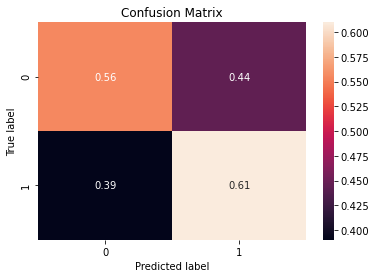

In [18]:
plot_confusion_matrix(y_test, y_pred, rf_model.classes_, 'Confusion Matrix')

In [39]:
clf_cv = RandomForestClassifier(n_estimators = 300, min_samples_split= 8, min_samples_leaf= 2, max_features= 'auto', max_depth = 10, bootstrap= False, n_jobs=-1)

clf_cv.fit(X_train, y_train)

f_importances = features_classifier_(X, clf_cv)
f_importances

,index,Feature,importance
0,83,Reputation (user),0.1528
1,0,Retweets,0.0823
2,1,Favorites,0.0739
3,55,Focusfuture,0.0503
4,80,Political polarisation (user based),0.0459
5,82,Moderacy polarisation (user based),0.0434
6,8,Text length,0.0390
7,9,Number of URLs,0.0389
8,84,User sentiment average,0.0354
9,27,Informal,0.0332


In [23]:
f_importances = f_importances[f_importances['importance'] > 0.008]
f_importances = f_importances.Feature.values
print(f_importances)

['user_Reputation' 'Favorites' 'Retweets' 'focusfuture'
 'user_moderacy_polarisation' 'user_political_polarisation' 'Text_len'
 'URLs_num' 'user_vadercompound_average' 'informal'
 'tweet_moderacy_polarisation_abweichung'
 'tweet_political_polarisation_abweichung' 'sexual' 'Hashtags_num'
 'article' 'work' 'netspeak' 'Mentions_num' 'motion'
 'tweet_vadercompound_abweichung' 'swear' 'readability' 'vader_com'
 'ipron']


In [24]:
X_new,y = get_X_y(df_tweetskb_user, f_importances)

(200000, 24)
(200000,)


In [24]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 300, min_samples_split= 8, min_samples_leaf= 2, max_features= 'auto', max_depth = 10, bootstrap= False, n_jobs=-1)
print_cross_val_score(clf_cv, X_new, y)

 percision : 0.61 +/- 0.012
 f1        : 0.54 +/- 0.009
 recall    : 0.48 +/- 0.014
Wall time: 55.8 s


In [78]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 300, min_samples_split= 8, min_samples_leaf= 2, max_features= 'auto', max_depth = 10, bootstrap= False, n_jobs=-1)
print_cross_val_score(clf_cv, X, y)

 percision : 0.61 +/- 0.012
 f1        : 0.53 +/- 0.016
 recall    : 0.47 +/- 0.020
Wall time: 57.2 s


***

In [68]:
n_estimators = [100, 200, 300, 400, 500, 1000]
max_features = ['sqrt', 'log2', 'auto']
max_depth =  [2,4,6,8,10]
min_samples_split = [2,4,8]
min_samples_leaf = [1,2,4]
bootstrap = [True, False]

In [69]:
param_grid = {'n_estimators' : n_estimators,
              'max_features' : max_features,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf,
              'bootstrap' : bootstrap}
print(param_grid)

{'n_estimators': [100, 200, 300, 400, 500, 1000], 'max_features': ['sqrt', 'log2', 'auto'], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 4, 8], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [26]:
rf_model = RandomForestClassifier()

In [70]:
%%time
clf_grid = GridSearchCV(rf_model, param_grid = param_grid, cv = 3, verbose = 10, n_jobs = -1)
clf_grid.fit(X_train,y_train)

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits
Wall time: 57min 54s


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [2, 4, 6, 8, 10],
                         'max_features': ['sqrt', 'log2', 'auto'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [100, 200, 300, 400, 500, 1000]},
             verbose=10)

In [71]:
clf_grid.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 300}

In [72]:
%%time
#20000 Tweets
clf_cv = RandomForestClassifier(n_estimators = 300, min_samples_split= 8, min_samples_leaf= 2, max_features= 'auto', max_depth = 10, bootstrap= False, n_jobs=-1)

print_cross_val_score(clf_cv, X_new, y)

 percision : 0.61 +/- 0.012
 f1        : 0.54 +/- 0.012
 recall    : 0.48 +/- 0.018
Wall time: 54.3 s


In [25]:
%%time
#200 000 Tweets
clf_cv = RandomForestClassifier(n_estimators = 300, min_samples_split= 8, min_samples_leaf= 2, max_features= 'auto', max_depth = 10, bootstrap= False, n_jobs=-1)

print_cross_val_score(clf_cv, X_new, y)

 percision : 0.57 +/- 0.003
 f1        : 0.64 +/- 0.003
 recall    : 0.72 +/- 0.003
Wall time: 8min 46s


*****************************************************
*****************************************************

## Plot feature Imortances
### Tweetkb (Content + User)

In [40]:
def plot_hist_Features_kb(l_features_importances, l_features, title):
    
    #colors = ['mediumorchid', 'gold', 'green', 'peru', 'red', 'mediumslateblue', 'deepskyblue', 'darkkhaki', 'brown']
    colors = ['steelblue','Black', 'peru', 'mediumslateblue', 'lightgreen']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [14,14]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, width = 0.5)
    ax.set_title('Random Forest', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    fig.tight_layout()
   #plt.legend()
    plt.savefig('../plots/'+title+'.pdf')


In [41]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:10]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:10]
l_features

['Reputation (user)',
 'Retweets',
 'Favorites',
 'Focusfuture',
 'Political polarisation (user based)',
 'Moderacy polarisation (user based)',
 'Text length',
 'Number of URLs',
 'User sentiment average',
 'Informal']

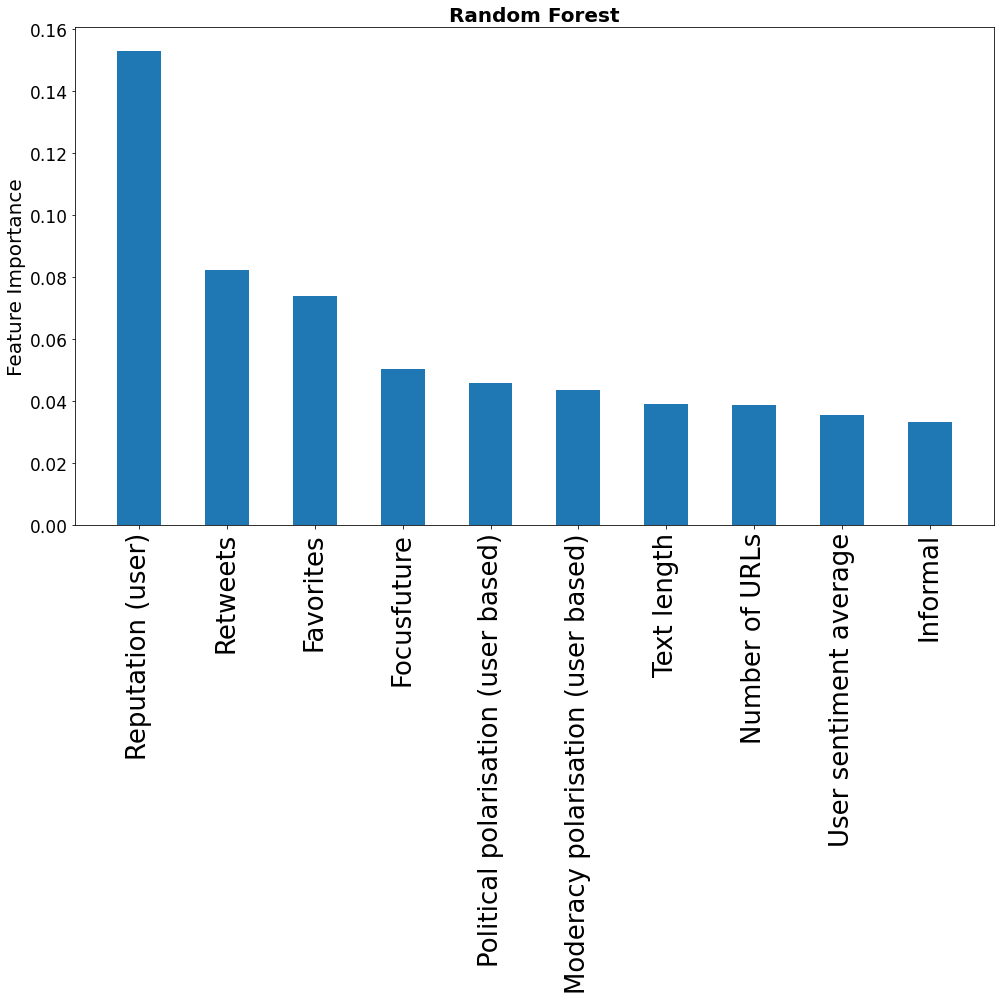

In [42]:
plot_hist_Features_kb(l_features_importances, l_features, 'Rf_tweetskb_content_user')

***********************************************************************
***********************************************************************

## Tweetskb
### Content only


In [43]:
features = df_tweetskb_user.columns
features

#features = features[2:83]
df_tweetskb_user = df_tweetskb_user[features.tolist()]
df_tweetskb_user = df_tweetskb_user.drop(columns=[  'User sentiment average', 'Tweet sentiment deviation', 'Tweet political polarisation deviation', 'Tweet science polarisation deviation', 'Tweet moderacy polarisation deviation'])
df_tweetskb_user = df_tweetskb_user.drop(columns=[  'Political polarisation (user based)', 'Science polarisation (user based)', 'Moderacy polarisation (user based)',  'Reputation (user)'])


In [44]:
features = df_tweetskb_user.columns
X,y = get_X_y(df_tweetskb_user, features)

(200000, 80)
(200000,)


In [45]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 80)
(40000, 80)
(160000,)
(40000,)


In [46]:
clf_cv = RandomForestClassifier(n_estimators = 300, min_samples_split= 8, min_samples_leaf= 2, max_features= 'auto', max_depth = 10, bootstrap= False, n_jobs=-1)
clf_cv.fit(X_train, y_train)

f_importances = features_classifier_(X, clf_cv)
f_importances

,index,Feature,importance
0,0,Retweets,0.1223
1,1,Favorites,0.1219
2,55,Focusfuture,0.0681
3,9,Number of URLs,0.0606
4,8,Text length,0.0562
5,27,Informal,0.0415
6,35,Sexual,0.0342
7,6,Number of hashtags,0.0336
8,21,Work,0.0319
9,62,Article,0.0317


In [93]:
f_importances = f_importances[f_importances['importance'] > 0.008]
f_importances = f_importances.Feature.values
print(f_importances)

['Favorites' 'Retweets' 'Focusfuture' 'Text length' 'Number of URLs'
 'Informal' 'Sexual' 'Article' 'Number of hashtags' 'Work' 'Netspeak'
 'Readability' 'Motion' 'Ipron' 'Sentiment compound' 'Swear'
 'Number od mentions' 'Emoji_sent' 'Sentiment negative'
 'Political polarisation (tweet based)' 'Sentiment positive' 'Social'
 'Number of Emojis' 'Negate' 'Sentiment neutral' 'Prep' 'Space'
 'Focuspast']


In [31]:
X_new,y = get_X_y(df_tweetskb_user, f_importances)

(200000, 27)
(200000,)


In [85]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 300, min_samples_split= 8, min_samples_leaf= 2, max_features= 'auto', max_depth = 10, bootstrap= False, n_jobs=-1)
print_cross_val_score(clf_cv, X_new, y)

 percision : 0.59 +/- 0.015
 f1        : 0.54 +/- 0.013
 recall    : 0.49 +/- 0.018
Wall time: 49 s


In [86]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 300, min_samples_split= 8, min_samples_leaf= 2, max_features= 'auto', max_depth = 10, bootstrap= False, n_jobs=-1)
print_cross_val_score(clf_cv, X, y)

 percision : 0.59 +/- 0.011
 f1        : 0.53 +/- 0.013
 recall    : 0.49 +/- 0.020
Wall time: 50 s


***************************************************
***************************************************

In [32]:
%%time
#200 000 Tweets
clf_cv = RandomForestClassifier(n_estimators = 300, min_samples_split= 8, min_samples_leaf= 2, max_features= 'auto', max_depth = 10, bootstrap= False, n_jobs=-1)

print_cross_val_score(clf_cv, X_new, y)

 percision : 0.57 +/- 0.003
 f1        : 0.62 +/- 0.002
 recall    : 0.68 +/- 0.004
Wall time: 9min 45s


***

## Plot feature Imortances
### Tweetkb (Content Only )

In [47]:
def plot_hist_Features_content_only_kb(l_features_importances, l_features, title):
    
    #colors = ['red', 'blue', 'peru', 'orange', 'yellow', 'mediumslateblue', 'deepskyblue', 'steelblue']
    colors = ['black', 'peru', 'mediumslateblue', 'lightblue', 'lightgreen']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [10,7]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, width = 0.5)
    ax.set_title('Random Forest', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    fig.tight_layout()
 
    #plt.legend()
    plt.savefig('../plots/'+title+'.pdf')


In [48]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:10]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:10]
l_features

['Retweets',
 'Favorites',
 'Focusfuture',
 'Number of URLs',
 'Text length',
 'Informal',
 'Sexual',
 'Number of hashtags',
 'Work',
 'Article']

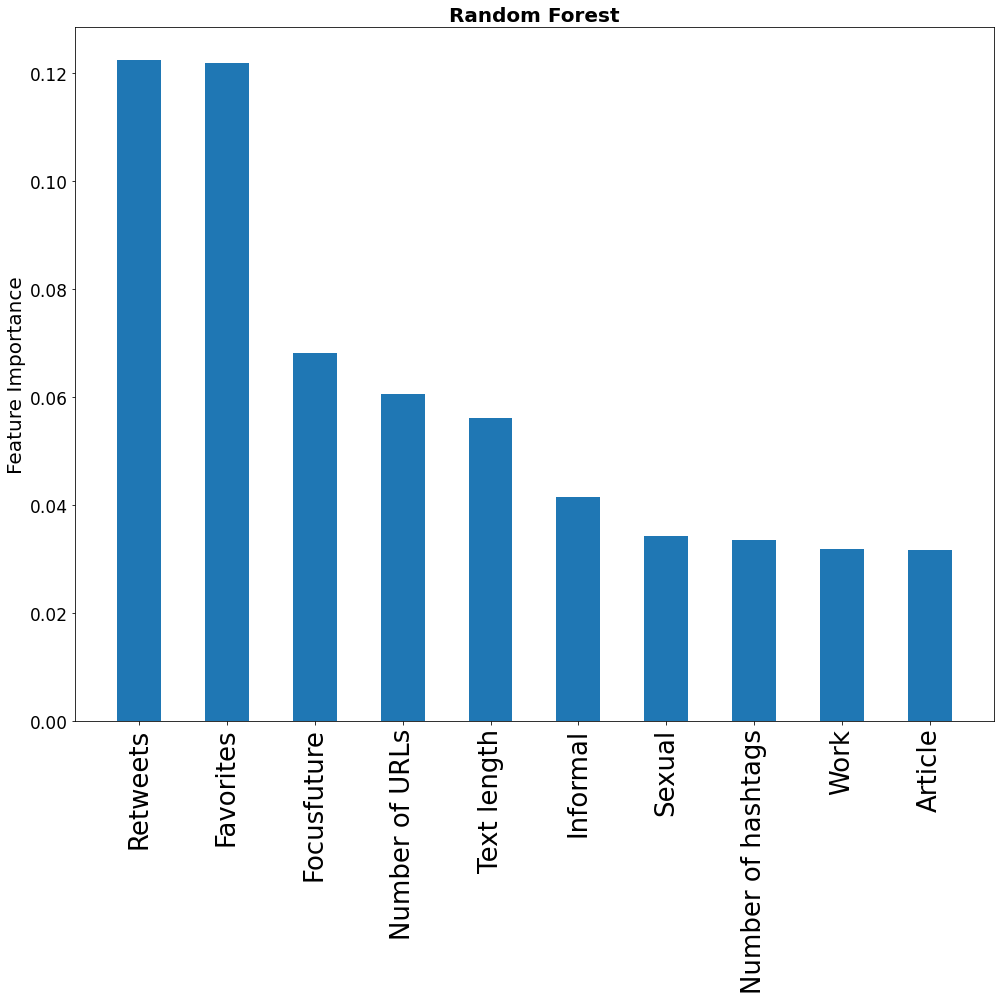

In [49]:
plot_hist_Features_content_only_kb(l_features_importances, l_features, 'Rf_tweetskb_content_only')